# Creating Two Neural Networks to Study The MNIST data

## Introduction

In this notebook, two neural networks are created that are able to look at images of handwritten digits and specify what digit it is. Specifically, the famous [MNIST dataset](http://yann.lecun.com/exdb/mnist/) will be used to train and test these two neural networks to do exactly this.

The first neural network that will be created will be a *fully connected* neural network
with five *hidden layers*. It will be found that with this architecture, the network is able to predict the digits with 96% accuracy.

The second neural network that will be created will be a *convolutional* neural network (CNN). This model will have an alternating series of *convolutional*, *max pooling* and *dropout* layers. It will be seen that the CNN that is created in this notebook will have a 99% accuracy in predicting the digits in the test dataset. 

## Data extraction and visualisation

First import the libraries needed in this notebook.

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical

from random import randrange, sample


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


The MNIST data can easily be obtained with the `tensorflow_datasets` library. In the cell below, if `download_data = True`, then tensorflow will download the MNIST data and store it in the directory `./data`. Otherwise, it will look for the data in the `./data` directory. 

The cell below loads the MNIST data into the variables `data` and `info`.

In [2]:
download_data = False

if download_data:
    
    data, info = tfds.load('mnist', with_info=True, data_dir='./data')

else:
        
    data, info = tfds.load('mnist', with_info=True, download=False, data_dir='./data')

W0716 15:26:47.348944 140267820738304 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Extract the training data and test data.

In [3]:
train_data = tfds.as_numpy(data['train'])
test_data = tfds.as_numpy(data['test'])

The digit images and labels are somewhat hidden in train_data and test_data. In order to obtain the data to work with, the function `extract_data` is defined below. The function:
* appends each digit image to an array X
* appends each digit label to the array y
* normalises each digit image by dividing by 255
* one-hot encodes the digit labels y. This means that if the digit was 1 then it is turned into the array [0, 1, {8 more zeros}]

In [4]:
def extract_data(generator):
    '''This functgion returns two numpy arrays X and y. Each element of X contains a 
       normalised 28x28 numpy array of a digit. The corresponding element in y is the 
       one-hot encoded digit label.'''
    
    X = []
    y = []

    for digit in generator:
    
        X.append(digit['image'])
        y.append(digit['label'])       

    X = np.array(X)/255
    y = np.array(y)

    y = to_categorical(y)
    
    return X, y

In [5]:
# NB: Since train_data and test_data are generators, this cell can only be run once.
# If this cell needs to be rerun, then the cell defining the generators train_data and
# test_data needs to be rerun again first. 
X, y = extract_data(train_data)
X_test, y_test = extract_data(test_data)

Of the digits in the training data, 15% of them will be declared as a validation set in order to probe the accuracy of the models that will be built.

In [6]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=0)

In order to check that the data has been loaded correctly, a sample element of the training data can be displayed.

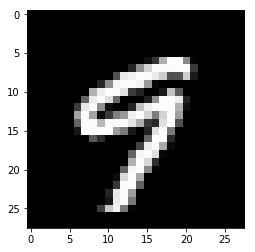

One-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [35]:
i = 10
plt.gray()
plt.imshow(X_train[i].reshape(28,28), interpolation='none')
plt.show()

print('One-hot encoded: {}'.format(y_train[i]))


Now that the digit images and labels have been specified, it is possible to begin constructing the neural networks that can model this data.

## The First Model

The first model that will be built will have:
* An initial *flat* layer of 784 neurons corresponding to each of the pixels in the 28x28 image.
* 5 hidden layers of 30 fully connected neurons each. These neurons will have a ReLU activation.
* A final layer of 10 neurons corresponding to the 10 digits. The neurons in this final layer will have a softmax activation. 

The model can be easily constucted using Keras as shown below. 

In [8]:
model = Sequential()

model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='softmax'))

A summary of the model can be made.

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                310       
Total para

The model will use:
* The adam optimizer
* Categorical cross entropy as a loss function to guide training
* Accuracy as a metric
* Be trained over 20 epochs

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model will be trained for 20 epochs. Each epoch represents a single pass through the training data. 

In [11]:
first_model_output = model.fit(X_train, y_train, epochs=20, validation_data=(X_validate, y_validate))
first_model = model

W0716 15:27:15.477333 140267820738304 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 5s 100us/step - loss: 0.3851 - acc: 0.8831 - val_loss: 0.2179 - val_acc: 0.9341
Epoch 2/20
51000/51000 [==============================] - 4s 84us/step - loss: 0.1714 - acc: 0.9500 - val_loss: 0.1538 - val_acc: 0.9543
Epoch 3/20
51000/51000 [==============================] - 4s 84us/step - loss: 0.1378 - acc: 0.9583 - val_loss: 0.1648 - val_acc: 0.9498
Epoch 4/20
51000/51000 [==============================] - 4s 85us/step - loss: 0.1164 - acc: 0.9646 - val_loss: 0.1426 - val_acc: 0.9577
Epoch 5/20
51000/51000 [==============================] - 4s 82us/step - loss: 0.1026 - acc: 0.9690 - val_loss: 0.1326 - val_acc: 0.9622
Epoch 6/20
51000/51000 [==============================] - 4s 85us/step - loss: 0.0926 - acc: 0.9715 - val_loss: 0.1474 - val_acc: 0.9599
Epoch 7/20
51000/51000 [==============================] - 4s 83us/step - loss: 0.0834 - acc: 0.9742 - val_loss: 0.1302 - val_acc

For every epoch, both the loss and accuracy for the training data and validation data can be extracted into a Pandas dataframe.

In [12]:
metrics_first = pd.DataFrame(first_model_output.history)

# The index of the metrics dataframe is zero indexed to the epoch number. As such, add one
# to the index so that Epoch 0 becomes Epoch 1.
metrics_first.index = metrics_first.index+1

A function will be created that will plot the accuracy/loss for the training/validation datasets.

In [15]:
def plot_accuracy_loss(df):
    '''The function takes a dataframe that is a Keras model's output history and plots
       the accuracy/loss information for both the training and validation datasets '''
    

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(data=df, ax=ax[0], x = df.index, y='acc', label='Training Data')
    sns.lineplot(data=df, ax=ax[0], x = df.index, y='val_acc', label='Validation Data')

    sns.lineplot(data=df, ax=ax[1], x = df.index, y='loss', label='Training Data')
    sns.lineplot(data=df, ax=ax[1], x = df.index, y='val_loss', label='Validation Data')

    fig.suptitle('Accuracy and Loss Across 20 Epochs', fontsize=20)

    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].xaxis.set_major_locator(MultipleLocator(1))
    ax[0].legend()

    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].xaxis.set_major_locator(MultipleLocator(1))
    ax[1].legend()


Having defined the function, it can be called to plot the accuracy and loss for the training and validation datasets across the 20 epochs.

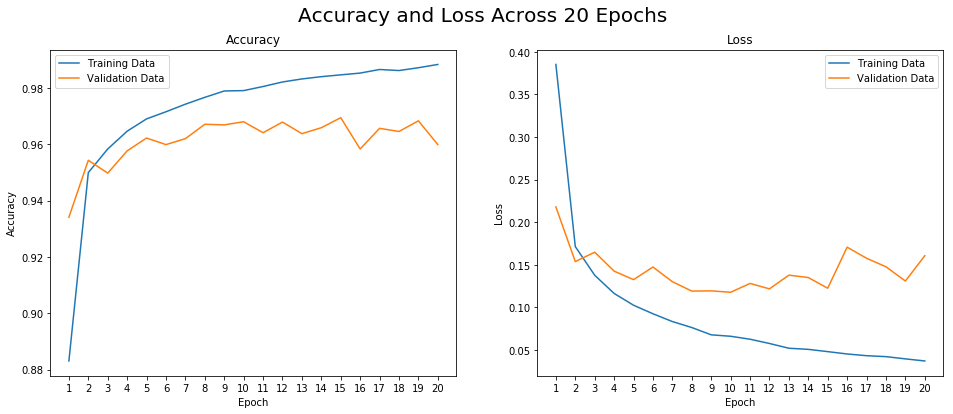

In [16]:
plot_accuracy_loss(metrics_first)

As can be seen in the plot on the top left, the accuracy of the training data quickly increases in the first three epochs, followed by a gradual, but non-stop climb towards 100%. This is despite the accuracy on the validation data plateauing  at around 96% after approximately the 6th epoch. This shows that after approximately 6 epochs, the model is  overfitted. 

Something similar happens to the loss. As can be seen in the plot on the top right, the loss for the training data approaches zero as the epochs increase. However, the loss for the validation data plateaus at around 0.15 after approximately 6 epochs. This is further evidence that the model is overfitting after 6 epochs.

An estimate of the accuracy of the model can be made by taking the mean and standard deviation of the accuracy on the validation data for the epochs 6 through to 20. 

In [18]:
mean = metrics_first['val_acc'][5:20].mean()
std = metrics_first['val_acc'][5:20].std()

print('Accuracy on validation data after overfitting is {:.3f} \u00B1 {:.3f}'.format(mean, std))

Accuracy on validation data after overfitting is 0.965 ± 0.003


To determine the accuracy of the model on the test data, predictions can be made.

In [19]:
predictions = first_model.predict(X_test)

The digit that will be predicted is simply the argument of the array that is the maximum.

In [20]:
predictions = [np.argmax(x) for x in predictions]

Create the list `y_test_digits` that reverses the one-hot coding.

In [21]:
y_test_digits = [np.argmax(x) for x in y_test]

Use the `accuracy_score` function from `sklearn.metrics` to determine the accuracy.

In [22]:
accuracy_score(predictions, y_test_digits)

0.9636

More simply, Keras allows the direct evaluation of the model with the following simple command. However, this command obscures the actual predictions of the model. The first number in the array below is the loss and the second element is the accuracy, which is the same as determined before.

In [23]:
first_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 40us/step


[0.1468432704907842, 0.9636]

In an effort to show what learning the model has made, a display of digits versus their predicted labels is shown below for a random selection of the test data.

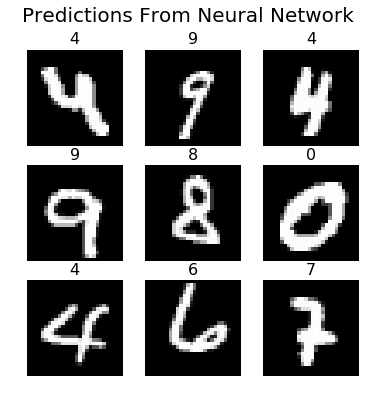

In [36]:
# Obtain a random selection of 9 digit images 
random_indices = [randrange(X_test.shape[0]) for x in range(9)]
random_indices_copy = random_indices # A copy has been made because pop will be used later
X_images = X_test[random_indices]

# Determine the predictions of these 9 images
predictions = first_model.predict(X_images)
predictions = [np.argmax(x) for x in predictions]

# Create the figure
fig, ax = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle('Predictions From Neural Network', fontsize=20)

for i in [0,1,2]:           # loop across the three rows
    for j in [0,1,2]:       # loop across the three columns
        
        # Obtain the first or next random index
        random_index = random_indices_copy.pop(0)
        
        # Obtain the prediction for this digit
        digit_prediction = predictions.pop(0)
        
        # Plot the digit and show the prediction
        ax[i,j].imshow(X_test[random_index].reshape(28,28), interpolation='none')
        ax[i,j].set_axis_off()
        ax[i,j].set_title(digit_prediction, fontsize=16)
    

## CNN Model

The second model that will be built will be a convolutional neural network. The network will have:
* An initial 20 convolutions of kernel size 5x5. 
* A 2x2 max pooling layer.
* A layer of 40 convolutions of kernel size 3x3.
* A 2x2 max pooling layer.
* A 0.2 dropout layer.
* A layer of 60 convolutions of kernel size 2x2.
* A 2x2 max pooling layer.
* A 0.2 dropout layer.

The result of this will be flattened and connected to:

* A dense layer of 100 neurons.
* A 0.2 dropout layer.
* A final dense layer of 10 neurons that corresponds to the 10 digits.

All neurons will have the ReLU activation, except for the last layer that will have a softmax activation.

The model can be easily constucted using Keras as shown below. 


In [25]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(60, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

W0716 15:31:33.643334 140267820738304 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


A summary of the model can be made.

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 40)        7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 60)          9660      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 60)          0         
__________

The model will use:
* The adam optimizer
* Categorical cross entropy as a loss function to guide training
* Accuracy as a metric
* Be trained on 20 epochs

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model will be trained for 20 epochs.

In [28]:
second_model_output = model.fit(X_train, y_train, epochs=20,  validation_data=(X_validate, y_validate))
second_model = model

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 44s 861us/step - loss: 0.3052 - acc: 0.9018 - val_loss: 0.0687 - val_acc: 0.9784
Epoch 2/20
51000/51000 [==============================] - 43s 835us/step - loss: 0.1004 - acc: 0.9688 - val_loss: 0.0569 - val_acc: 0.9817
Epoch 3/20
51000/51000 [==============================] - 45s 889us/step - loss: 0.0751 - acc: 0.9769 - val_loss: 0.0419 - val_acc: 0.9873
Epoch 4/20
51000/51000 [==============================] - 46s 900us/step - loss: 0.0632 - acc: 0.9808 - val_loss: 0.0418 - val_acc: 0.9874
Epoch 5/20
51000/51000 [==============================] - 44s 862us/step - loss: 0.0577 - acc: 0.9821 - val_loss: 0.0360 - val_acc: 0.9894
Epoch 6/20
51000/51000 [==============================] - 42s 824us/step - loss: 0.0514 - acc: 0.9844 - val_loss: 0.0360 - val_acc: 0.9888
Epoch 7/20
51000/51000 [==============================] - 42s 828us/step - loss: 0.0453 - acc: 0.9867 - val_loss: 0.0

For every epoch, both the loss and accuracy for the training data and validation data can be extracted into a Pandas dataframe.

In [29]:
metrics_second = pd.DataFrame(second_model_output.history)

# The index of the dataframe is zero indexed to the epoch number. As such, add one
# to the index so that Epoch 0 becomes Epoch 1.
metrics_second.index = metrics_second.index+1

The accuracy and loss across the 20 epochs can be plotted for the model using the previously defined function `plot_accuracy_loss`. 

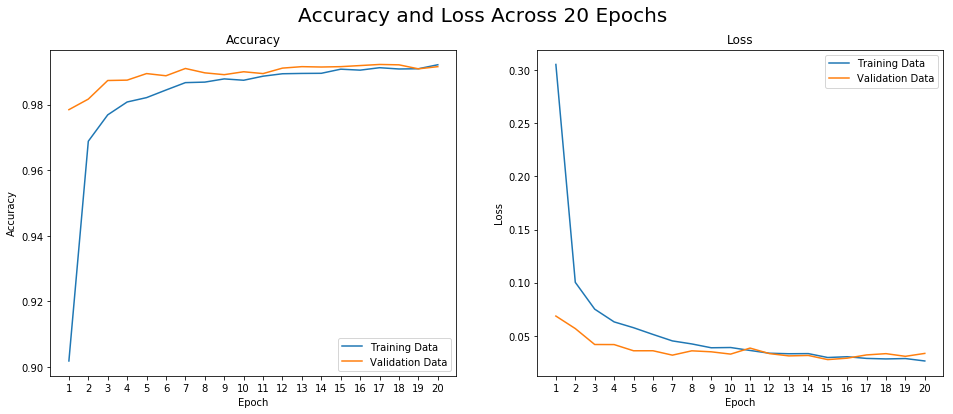

In [30]:
plot_accuracy_loss(metrics_second)

As can be seen on the top left plot, the model performs overall better on the validation data than the training data. This is due to the two dropout layers that were used in the network that helped prevent overfitting from occuring. The plot shows that after around the 11th epoch, the model's ability to predict the validation data begins to plateau. 
The plot on the top right shows a similar plateau of theh loss in the validation data around the 11th epoch. 

The model's accuracy on the test data can be evaluated. 

In [31]:
second_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 4s 399us/step


[0.022483871061735407, 0.993]

## Where did the predictions go wrong?

It would be interesting to see what images the CNN is unable to correctly predict. First determine all the predictions on the X_test dataset and reverse the one-hot encoding on the y_test.

In [39]:
predictions = second_model.predict(X_test)
predictions = [np.argmax(x) for x in predictions]
y_test_digits = [np.argmax(x) for x in y_test]

Determine which indices of the predictions are incorrect.

In [40]:
incorrect = []

# Cycle through the indices of the y_test_digits and see if the actual digit matches
# the prediction
for i in range(len(y_test_digits)):
    
    if y_test_digits[i] != predictions[i]:
        
        incorrect.append(i)

Plot a random sample of 9 digits that were predicted incorrectly. 

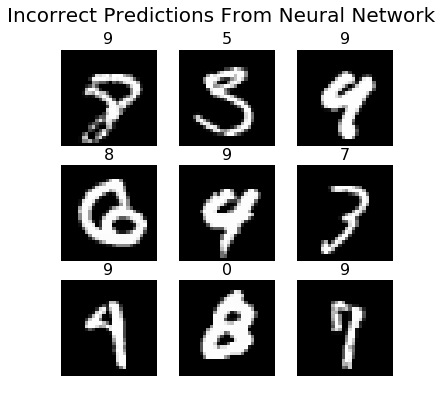

In [41]:
# Obtain a random selection of the incorrect of 9 digit images 
incorrect_sample = sample(incorrect, 9)
incorrect_sample_copy = incorrect_sample # A copy has been made because pop will be used later
X_images = X_test[incorrect_sample]

# Determine the predictions of these 9 images
#predictions_incorrect_sample = predictions[incorrect_sample]

predictions_incorrect_sample = []

for i in incorrect_sample:
    predictions_incorrect_sample.append(predictions[i])


# Create the figure
fig, ax = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle('Incorrect Predictions From Neural Network', fontsize=20)

for i in [0,1,2]:           # loop across the three rows
    for j in [0,1,2]:       # loop across the three columns
        
        # Obtain the first or next random index
        random_index = incorrect_sample.pop(0)
        
        # Obtain the prediction for this digit
        digit_prediction = predictions_incorrect_sample.pop(0)
        
        # Plot the digit and show the prediction
        ax[i,j].imshow(X_test[random_index].reshape(28,28), interpolation='none')
        ax[i,j].set_axis_off()
        ax[i,j].set_title(digit_prediction, fontsize=16)

As can be seen, the images that the CNN provided incorrect predictions are either badly drawn or have features that trick the model.

## Conclusion

In this notebook, two neural network models were constructed that when given an image of a handwritten digit, they were able to determine what that digit was. The dataset that was used was the MNIST dataset that was obtained through the Tensorflow package.
The first neural network that was constructed was a neural network that had five hidden layers. It was found to have an accuracy of 96% on the test data. 
The second neural network that was constructed was a convolutional neural network. This network was able to achieve an accuracy of 99%. 
Finally, a sample of images that the CNN model was unable to predict correctly was studied.